In [4]:
## BEGIN S3FS IMPORT SNIPPET ##
import os, sys
#s3_home = os.path.join('/home', os.environ.get('JUPYTERHUB_USER'))
#try: sys.path.remove(s3_home)
#except Exception: pass

os.chdir('C:/Users/dsrus/')
 
# BEGIN PYTHON IMPORTS #

import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import load_model

import numpy as np

from sklearn.model_selection import train_test_split
import os
import matplotlib.pyplot as plt

###my own stuff##
import glob
import cv2
# END PYTHON IMPORTS #
#s3_home = os.path.join(s3_home,'work/final/4_ocean/4B_ship_classification_with_Sentinel-1_data')
#os.chdir(s3_home)
#sys.path.append(s3_home)
## END S3FS IMPORT SNIPPET ##

In [5]:
import os, sys
print(os.path.expanduser('~'))

C:\Users\dsrus


In [6]:
import tensorflow as tf
print ('tensorflow version', tf.__version__)

x = [[3.]]
y = [[4.]]
print('Result: {}'.format(tf.matmul(x, y))) 

tensorflow version 2.10.1
Result: [[12.]]


In [7]:
from osgeo import gdal
from osgeo import ogr
from osgeo import osr
from osgeo import gdal_array

In [8]:
ds = gdal.Open('C:/Users/dsrus/Desktop/Workspace/ObjectDetection/ImageChips/images/000000000000.tif')
fullarray = np.array(ds.ReadAsArray())

In [9]:
X_data = []
files = glob.glob ("C:/Users/dsrus/Desktop/Workspace/ObjectDetection/ImageChips/images/*.tif")
for myFile in files:
    image = cv2.imread (myFile)
    X_data.append (image)

print('X_data shape:', np.array(X_data).shape)

X_data shape: (1385, 256, 256, 3)


In [19]:
label_data = []
labels = glob.glob('C:/Users/dsrus/Desktop/Workspace/ObjectDetection/ImageChips/labels/*.xml')
for myFile in labels:
    label = 0
    label_data.append (label)
print('label_data shape:', np.array(label_data).shape)

label_data shape: (1385,)


In [37]:

# save numpy array as npz file
from numpy import asarray
from numpy import savez_compressed
#savez_compressed('pool_set.npz', X_data, label_data)
savez_compressed('pool_set.npz', X_data, label_data)

In [38]:
data = np.load('C:/Users/dsrus/pool_set.npz') 
files = data.files 
files

['arr_0', 'arr_1']

In [39]:
print('Shape - "arr_0" item: ' + str(data['arr_0'].shape))
print('Shape - "arr_1" item: ' + str(data['arr_1'].shape))

Shape - "arr_0" item: (1385, 256, 256, 3)
Shape - "arr_1" item: (1385,)


Pool: 0


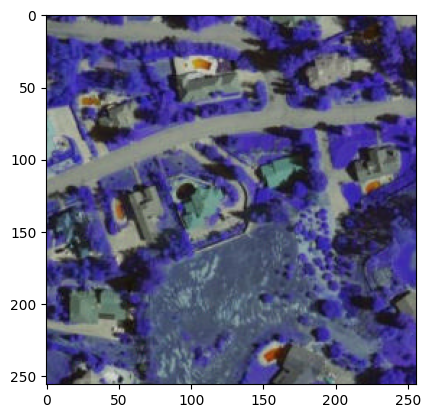

In [69]:
index = 1300
plt.imshow(data['arr_0'][index,:,:])
print('Pool: ' + str(data['arr_1'][index]))

In [42]:
X = data['arr_0']
y = data['arr_1']

In [47]:
inputs = tf.keras.layers.Input(shape=(256, 256, 3))
inputs

<KerasTensor: shape=(None, 256, 256, 3) dtype=float32 (created by layer 'input_3')>

In [48]:
vgg = VGG16(include_top=False,
            weights=None,
            input_tensor=inputs,
            pooling='avg')

vgg

In [49]:
inp = vgg.input
inp

<KerasTensor: shape=(None, 256, 256, 3) dtype=float32 (created by layer 'input_3')>

In [50]:
dense1 = tf.keras.layers.Dense(512, activation='relu')(vgg.output)
dropout1 = tf.keras.layers.Dropout(0.5)(dense1)

dense2 = tf.keras.layers.Dense(128, activation='relu')(dropout1)
dropout2 = tf.keras.layers.Dropout(0.5)(dense2)

pred = tf.keras.layers.Dense(3, activation='softmax')(dropout2)
pred

<KerasTensor: shape=(None, 3) dtype=float32 (created by layer 'dense_2')>

In [51]:
model = tf.keras.Model(inp, pred)
model

In [59]:
plot_model(model, to_file='C:/Users/dsrus/Desktop/Workspace/ObjectDetection/vgg.png', show_shapes=True)
print(model.summary())

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 256, 256, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 256, 256, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 128, 128, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 128, 128, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 128, 128

In [60]:
opt = tf.keras.optimizers.SGD(learning_rate=0.001, momentum=0.9, nesterov=True, name='SGD')

model.compile(optimizer=opt,
              loss=tf.keras.losses.categorical_crossentropy,
              metrics=['accuracy'])

model

In [61]:
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.25,
                                                    random_state=42)

In [62]:
print(X_train.shape)
print(X_test.shape)

(1038, 256, 256, 3)
(347, 256, 256, 3)


In [63]:
y_train = tf.keras.utils.to_categorical(y_train, num_classes=3)
y_test = tf.keras.utils.to_categorical(y_test, num_classes=3)


In [64]:
check = tf.keras.callbacks.ModelCheckpoint('C:/Users/dsrus/Desktop/Workspace/ObjectDetection/vgg.h5',
                                           monitor='val_accuracy',
                                           verbose=0,
                                           save_best_only=True, mode='auto')

In [65]:
log = tf.keras.callbacks.CSVLogger('C:/Users/dsrus/Desktop/Workspace/ObjectDetection/vgg.txt')

With only one class type in my dataset, i realize here I've chosen the wrong tool (VGG16) and need to adapt a SSD for the object detection, but it's still been a worthy exercise.

In [66]:
import multiprocessing
from timeit import default_timer as timer

start = timer()
cpu_count = multiprocessing.cpu_count()
print(f"cpu: {cpu_count} found")

model.fit(X_train, y_train,
          batch_size=12,
          epochs=2,
#          epochs=150,
          verbose=1,
          validation_data=(X_test, y_test),
          steps_per_epoch = 25,
          max_queue_size=10,
          workers=cpu_count,
          use_multiprocessing=cpu_count > 1,
          callbacks=[check, log])

end = timer()
print('Elapsed time: ' + str(end - start))

cpu: 20 found
Epoch 1/2
25/25 [==============================] - 109s 4s/step - loss: 0.1358 - accuracy: 0.9500 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 2/2
25/25 [==============================] - 110s 4s/step - loss: 5.4958e-04 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Elapsed time: 218.91898419999052


In [68]:
model = load_model('C:/Users/dsrus/Desktop/Workspace/ObjectDetection//vgg.h5')

_, test_acc = model.evaluate(X_test, y_test)

print('Test_acc: %.4f' % test_acc)

11/11 [==============================] - 24s 2s/step - loss: 0.0000e+00 - accuracy: 1.0000
Test_acc: 1.0000
